<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Improved Neural Network Strategy

## Importing the required libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tpqoa ## https://github.com/yhilpisch/tpqoa
import tensorflow as tf
from tensorflow import keras

In [47]:
def set_seeds(seed=500):
    ''' Function to set seeds for all
        random number generators.
    '''
#    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seeds()

### Graph Formating

In [48]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

## Generate Class

In [49]:
class ImprovedNN:
    ''' This class downloads data from OANDA,
    and prepares it for Modeling and Backtesting
    '''

    def __init__(self, instrument, start, end, granularity, price):
        ''' Init function is expecting a Symbol to filter the data
        
        Parameters:
        ===========
        instrument: string
            valid instrument name
        start, end: datetime, str
            Python datetime or string objects for start and end
        granularity: string
            a string like 'S5', 'M1' or 'D'
        price: string
            one of 'A' (ask) or 'B' (bid)
        '''
        self.instrument = instrument
        self.start = start
        self.end = end
        self.granularity = granularity
        self.price = price
        
        api = tpqoa.tpqoa('../config.cfg')
        
        filename = f'../oanda/' 
        filename += f'oanda_{instrument}_{start}_{end}_'
        filename += f'{granularity}_{price}.csv'
        filename = filename.replace(' ', '_').replace('-', '_').replace(':', '_')
        try:
            self.rawdata = pd.read_csv(filename, index_col=0, parse_dates=True)
        except:
            self.rawdata = api.get_history(instrument, start,
                                       end, granularity,
                                       price)
            self.rawdata.to_csv(filename)
            print(60*"=")
            print("Created CSV File")
            print(filename)
            print(60*"=")
        
        self.rawdata = pd.DataFrame(self.rawdata['c'])
        self.rawdata.columns = ['price']
        
        self.generate_columns()

        
    def generate_columns(self):
        ''' Generates the basic columns on the downloaded data '''
        
        # Calculates the logarithmic return
        self.data = self.rawdata[:-1].copy()
        self.data['returns'] = np.log(self.data/self.data.shift(1))
        self.data['direction'] = np.where(self.data['returns'] > 0 , 1,0)

        # Calculates Simple Moving Averages with a long and a short window
        self.data['SMA1'] = self.data['price'].rolling(20).mean()
        self.data['SMA2'] = self.data['price'].rolling(60).mean()
        self.data['dSMA'] = self.data['SMA1'] - self.data['SMA2']

        # Calculates Equally Weighted Moving Average with a long and a short halflife
        self.data['EWMA1'] = self.data['price'].ewm(halflife=20).mean()
        self.data['EWMA2'] = self.data['price'].ewm(halflife=60).mean()
        self.data['dEWMA'] = self.data['EWMA1'] - self.data['EWMA2']

        # Calculates the moving standard deviation
        self.data['vol1'] = self.data['price'].rolling(20).std()
        self.data['vol2'] = self.data['price'].rolling(60).std()

        # Deletes NA rows
        self.data.dropna(inplace=True)
        
    def createLags(self, lags=5):
        ''' Create the lags as features.
        
        Parameters:
        ===========
        lags: int
            number of lags to be created
            default = 5
        '''
        
        #Creating the lags
        features = list(self.data.columns)
        self.cols = list()
        for f in features:    
            #Create lags
            for lag in range(1, lags + 1):
                col = f'{f}_lag_{lag}'
                self.cols.append(col)
                self.data[col] = self.data[f].shift(lag)

        self.data.dropna(inplace=True)
    
    def splitData(self, split1=0.7, split2=0.9):
        ''' Split the data into train,
        validation and test
        
        Parameters:
        ===========
        split1: int
            Proportion of sample used to train
            default = 0.7
        split2: int
            (1 - split2) is the proportion of sample
            used to test
            default = 0.9
        '''
        
        split = [ int(len(self.data) * split1) , int(len(self.data) * split2) ]
        self.train = self.data.iloc[:split[0]].copy()
        self.val = self.data.iloc[split[0]:split[1]].copy()
        self.test = self.data.iloc[split[1]:].copy()

    def normalizeFeatures(self):
        ''' Normalized the features created  with the lags'''
        
        mu, std = self.train.mean(), self.train.std()
        self.train_ = (self.train - mu) / std
        self.val_ = (self.val - mu) / std
        self.test_ = (self.test - mu) / std

In [50]:
instrument = 'USD_CAD'
start = '2019-10-31'
end = '2020-07-31'
granularity = 'M30'
price = 'M'

In [51]:
NN = ImprovedNN(instrument, start, end, granularity, price)

In [52]:
NN.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9244 entries, 2019-11-01 05:30:00 to 2020-07-30 23:00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      9244 non-null   float64
 1   returns    9244 non-null   float64
 2   direction  9244 non-null   int64  
 3   SMA1       9244 non-null   float64
 4   SMA2       9244 non-null   float64
 5   dSMA       9244 non-null   float64
 6   EWMA1      9244 non-null   float64
 7   EWMA2      9244 non-null   float64
 8   dEWMA      9244 non-null   float64
 9   vol1       9244 non-null   float64
 10  vol2       9244 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 866.6 KB


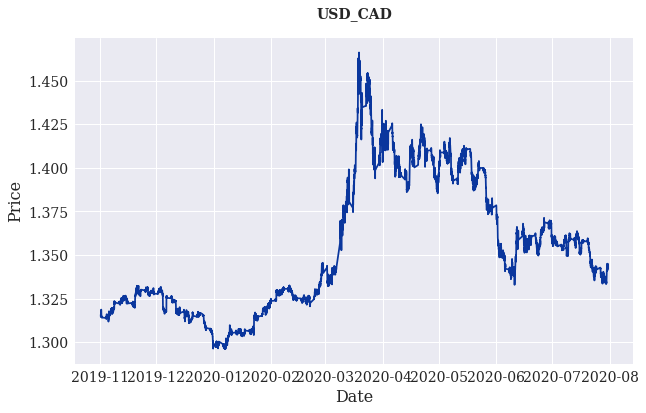

In [53]:
plt.figure()
plt.title(instrument,fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(NN.data['price'], color='#0A369D');
# plt.savefig('price.png', facecolor='None')

In [54]:
NN.data.tail()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
time,,,,,,,,,,,
2020-07-30 21:00:00,1.34280,0.000447,1,1.343209,1.338729,0.004480,1.340209,1.338921,0.001288,0.001117,0.004010
2020-07-30 21:30:00,1.34272,-0.000060,0,1.343282,1.338823,0.004459,1.340295,1.338965,0.001330,0.001027,0.004037
2020-07-30 22:00:00,1.34222,-0.000372,0,1.343299,1.338901,0.004398,1.340360,1.339003,0.001358,0.001005,0.004057
2020-07-30 22:30:00,1.34192,-0.000224,0,1.343277,1.338981,0.004296,1.340413,1.339036,0.001377,0.001031,0.004069
2020-07-30 23:00:00,1.34156,-0.000268,0,1.343283,1.339058,0.004224,1.340452,1.339065,0.001387,0.001020,0.004073


In [55]:
NN.createLags(6)

In [56]:
NN.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9238 entries, 2019-11-01 08:30:00 to 2020-07-30 23:00:00
Data columns (total 77 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            9238 non-null   float64
 1   returns          9238 non-null   float64
 2   direction        9238 non-null   int64  
 3   SMA1             9238 non-null   float64
 4   SMA2             9238 non-null   float64
 5   dSMA             9238 non-null   float64
 6   EWMA1            9238 non-null   float64
 7   EWMA2            9238 non-null   float64
 8   dEWMA            9238 non-null   float64
 9   vol1             9238 non-null   float64
 10  vol2             9238 non-null   float64
 11  price_lag_1      9238 non-null   float64
 12  price_lag_2      9238 non-null   float64
 13  price_lag_3      9238 non-null   float64
 14  price_lag_4      9238 non-null   float64
 15  price_lag_5      9238 non-null   float64
 16  price_lag_6      9238 no

In [57]:
NN.splitData()

In [58]:
NN.train.shape

(6466, 77)

In [59]:
NN.val.shape

(1848, 77)

In [60]:
NN.test.shape

(924, 77)

In [61]:
NN.normalizeFeatures()

In [62]:
NN.train_.shape

(6466, 77)

In [63]:
NN.train.iloc[:,:15].describe().round(2)

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2,price_lag_1,price_lag_2,price_lag_3,price_lag_4
count,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00
mean,1.35,0.00,0.49,1.35,1.35,0.00,1.35,1.35,0.00,0.00,0.00,1.35,1.35,1.35,1.35
std,0.04,0.00,0.50,0.04,0.04,0.00,0.04,0.04,0.00,0.00,0.00,0.04,0.04,0.04,0.04
min,1.30,-0.01,0.00,1.30,1.30,-0.01,1.30,1.30,-0.01,0.00,0.00,1.30,1.30,1.30,1.30
25%,1.32,-0.00,0.00,1.32,1.32,-0.00,1.32,1.32,-0.00,0.00,0.00,1.32,1.32,1.32,1.32
50%,1.33,0.00,0.00,1.33,1.33,0.00,1.33,1.33,0.00,0.00,0.00,1.33,1.33,1.33,1.33
75%,1.40,0.00,1.00,1.40,1.40,0.00,1.40,1.40,0.00,0.00,0.00,1.40,1.40,1.40,1.40
max,1.47,0.01,1.00,1.46,1.45,0.02,1.45,1.44,0.02,0.01,0.02,1.47,1.47,1.47,1.47


In [64]:
NN.train_.iloc[:,:15].describe().round(2)

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2,price_lag_1,price_lag_2,price_lag_3,price_lag_4
count,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00,6466.00
mean,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.24,-8.70,-0.99,-1.23,-1.22,-4.52,-1.22,-1.17,-3.36,-0.89,-0.93,-1.24,-1.24,-1.24,-1.24
25%,-0.75,-0.31,-0.99,-0.75,-0.75,-0.38,-0.74,-0.75,-0.46,-0.63,-0.69,-0.75,-0.75,-0.75,-0.75
50%,-0.50,-0.01,-0.99,-0.49,-0.49,-0.05,-0.49,-0.50,-0.08,-0.38,-0.41,-0.50,-0.50,-0.50,-0.50
75%,1.08,0.29,1.01,1.08,1.09,0.31,1.11,1.19,0.29,0.22,0.42,1.08,1.08,1.08,1.08
max,2.67,12.52,1.01,2.48,2.39,5.64,2.30,2.18,5.61,6.64,5.86,2.67,2.67,2.67,2.68


## Modelling the Neural Network

In [65]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [66]:
model = Sequential()
    
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001),
                input_dim=len(NN.cols), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001),
                activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  
    
model.compile(loss='binary_crossentropy',  
                       optimizer='adam',  
                       metrics=['acc'])  

In [68]:
callbacks = [EarlyStopping(monitor='val_acc', patience=20)]

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               8576      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 25,217
Trainable params: 25,217
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(NN.train_[NN.cols],
                    NN.train['direction'], 
                      epochs=125, 
                      verbose=False,
                      batch_size=32,
                      validation_data=(NN.val_[NN.cols],NN.val['direction']),
                      callbacks=callbacks)

In [71]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

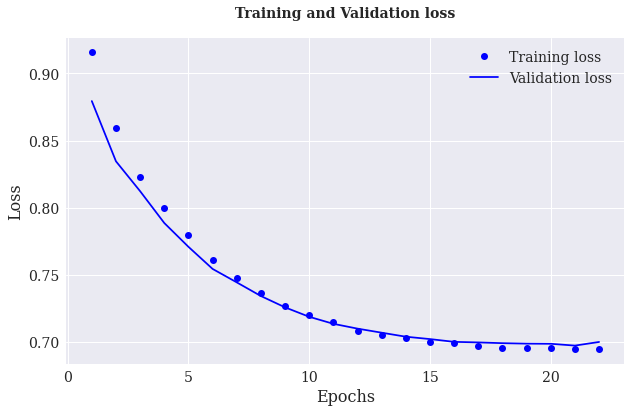

In [72]:
plt.plot(epochs, loss_values,'bo', label='Training loss')
plt.plot(epochs, val_loss_values,'b', label='Validation loss')
plt.title('Training and Validation loss',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
# plt.savefig('Loss.png', facecolor='None')

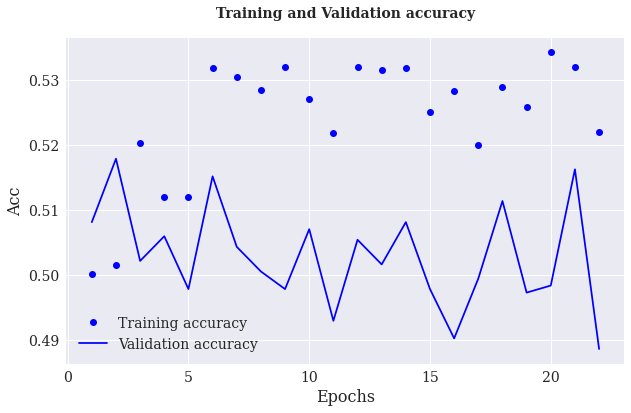

In [73]:
plt.plot(epochs, acc_values,'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values,'b', label='Validation accuracy')
plt.title('Training and Validation accuracy',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend();
# plt.savefig('Accuracy.png', facecolor='None')

In [74]:
res = pd.DataFrame(model.history.history)

In [75]:
res.tail(3)

,val_loss,val_acc,loss,acc
19,0.698466,0.498377,0.695298,0.534179
20,0.697123,0.516234,0.694738,0.532014
21,0.699832,0.488636,0.694603,0.521961


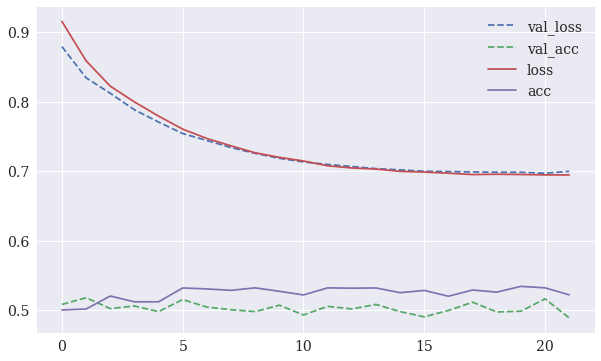

In [76]:
res.plot(figsize=(10, 6), style=['--', '--', '-', '-']);

In [31]:
backtest = backtest[5:].copy()

backtest['pred']=model.predict(X_test).round()
backtest['pred']=np.where(backtest['pred']==1,1,-1)  

backtest['strategy'] = backtest['pred'] * backtest['returns']

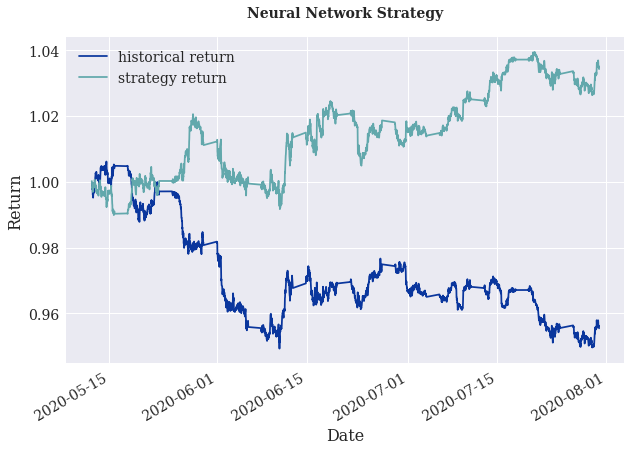

In [32]:
plt.figure()
plt.title('Neural Network Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(backtest['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(backtest['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('classification_strategy.png', facecolor='None')

In [33]:
backtest[['returns', 'strategy']].sum().apply(np.exp)

returns     0.955466
strategy    1.034271
dtype: float64

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>